# Problem Set: Risk Measures with Stochastic Volatility Models

## Introduction

In this problem set, you will implement and compare two different approaches for estimating financial risk measures:

1. Kalman Filter with Maximum Likelihood Estimation (MLE)
2. EGARCH model

You will use these methods to compute two important risk metrics:
- Value-at-Risk (VaR)
- Expected Shortfall (ES)


## Learning Objectives

- Understand how to implement a Kalman Filter for stochastic volatility models
- Apply Maximum Likelihood Estimation (MLE) for parameter optimization
- Compare the Kalman Filter approach with EGARCH models
- Implement and interpret Value-at-Risk (VaR) and Expected Shortfall (ES)
- Assess model performance using coverage ratio analysis

## Requirements

The following libraries are needed for this problem set:

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from arch import arch_model
import scipy.stats as stats
from scipy.integrate import quad
from scipy.optimize import minimize

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## Part 1: Simulate Data from a Stochastic Volatility Model

We'll start by generating simulated data from a stochastic volatility (SV) model. This will allow us to evaluate the performance of our estimation methods against known "ground truth" parameters.

### Model Specification

The SV model we'll use has the following structure:

$$r_t = \bar{\sigma} \cdot e^{0.5 h_t} \cdot \epsilon_t,  \quad \epsilon_t \sim N(0,1)$$
$$h_t = \phi \cdot h_{t-1} + \eta_t, \quad \eta_t \sim N(0, \sigma_{\eta}^2)$$
$$h_0 \sim N\left(0, \frac{\sigma_{\eta}^2}{1 - \phi^2}\right)$$

Where:
- $r_t$ is the return at time $t$
- $h_t$ is the (unobserved) log-volatility process
- $\phi$ is the persistence parameter of the log-volatility process
- $\sigma_{\eta}$ is the volatility of the log-volatility process
- $\bar{\sigma}$ is a scale parameter

### Task 1.1: Simulate SV data

Complete the code below to simulate data from an SV model:

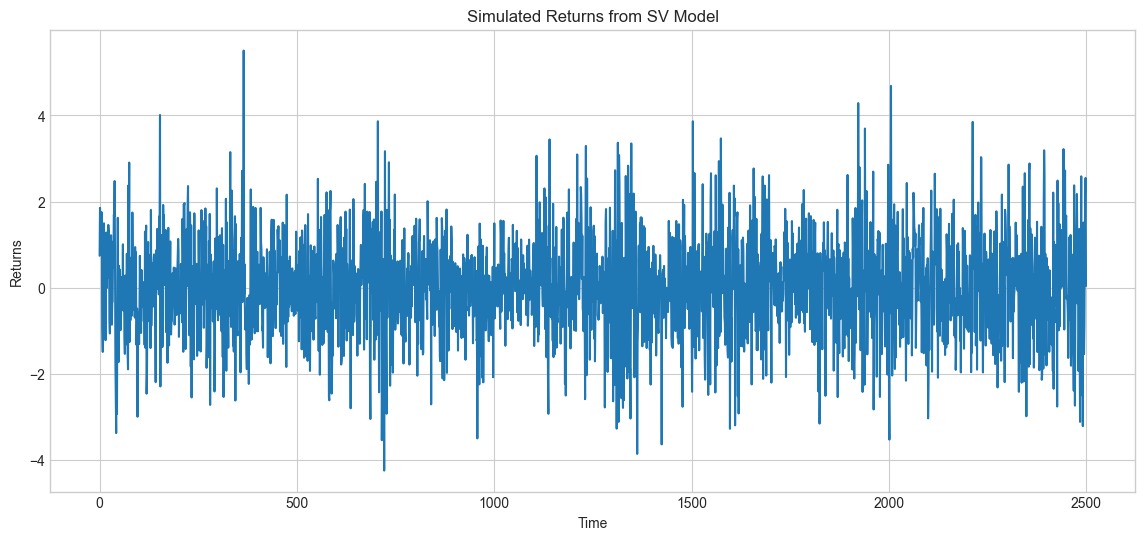

In [2]:
# Set random seed for reproducibility
np.random.seed(1234)

# Sample size
T = 2500

# SV model parameters
phi = 0.95        # Persistence parameter (close to 1 means high persistence)
sigma_eta = 0.2   # Volatility of log-volatility process
sigma = 1.0       # Scale parameter

# Generate the latent log-volatility process h_t
h_true = np.zeros(T)

# Initialize from the stationary distribution of the AR(1) process
# TODO: Initialize h_true[0] from the appropriate normal distribution
h_true[0] = np.random.normal(loc=0, scale=np.sqrt(sigma_eta**2 / (1 - phi**2)))

# TODO: Generate the AR(1) process for log-volatility
for t in range(1, T):
    h_true[t] = phi * h_true[t-1] + np.random.normal(0, sigma_eta)
    pass

# TODO: Generate returns with stochastic volatility
epsilon = np.random.normal(0, 1, T)
r = sigma * np.exp(0.5 * h_true) * epsilon



# Plot the simulated returns
plt.figure(figsize=(14, 6))
plt.plot(r)
plt.title('Simulated Returns from SV Model')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.grid(True)
plt.show()

## Part 2: Kalman Filter Implementation

To estimate the SV model, we need to linearize it first using the Harvey Transform.

### The Harvey Transform

1. Original model: $r_t = \bar{\sigma} \cdot e^{0.5 h_t} \cdot \epsilon_t$
2. Square both sides: $r_t^2 = \bar{\sigma}^2 \cdot e^{h_t} \cdot \epsilon_t^2$
3. Take logarithms: $\log(r_t^2) = \log(\bar{\sigma}^2) + h_t + \log(\epsilon_t^2)$

### Task 2.1: Implement the Kalman Filter

Complete the Kalman Filter implementation below:

In [3]:
def kalman_filter(y, a, B, Phi, H, Q, a1, P1, return_loglike=False):
    """
    Kalman Filter for an SV model.
    
    Parameters
    ----------
    y : array-like of shape (T,)
        Observations of the log-squared-return series
    a : float
        Intercept in the measurement equation
    B : float
        Coefficient on the state in the measurement equation
    Phi : float
        Coefficient on the state in the transition equation
    H : float
        Measurement error variance
    Q : float
        State innovation variance
    a1 : float
        Mean of the initial state
    P1 : float
        Variance of the initial state
    return_loglike : boolean, optional
        If True, returns the negative log-likelihood
    
    Returns
    ------
    If return_loglike:
        negative log-likelihood
    else:
        a_post, P_post, a_prior, P_prior arrays
    """
    Tsize = len(y)
    a_prior = np.zeros(Tsize)
    P_prior = np.zeros(Tsize)
    a_post  = np.zeros(Tsize)
    P_post  = np.zeros(Tsize)

    a_prior[0] = a1
    P_prior[0] = P1

    log_like = 0.0

    for t in range(Tsize):
        # TODO: Implement the measurement update
        # Calculate F_t, K_t (Kalman gain), v_t (prediction error)
        v_t = y[t] - (a + B * a_prior[t])
        F_t = B * P_prior[t] * B + H
        K_t = P_prior[t] * B / F_t
        
        # TODO: Update log-likelihood
        log_like += -0.5 * (np.log(2 * np.pi) + np.log(F_t) + (v_t**2) / F_t)

        # TODO: Update a_post[t] and P_post[t]
        a_post[t] = a_prior[t] + K_t * v_t
        P_post[t] = (1 - K_t * B) * P_prior[t]

        # TODO: Time update (except final step)
        if t < Tsize - 1:
            # Update a_prior[t+1] and P_prior[t+1]
            a_prior[t+1] = Phi * a_post[t]
            P_prior[t+1] = Phi**2 * P_post[t] + Q
            pass

    if return_loglike:
        return -log_like
    else:
        return a_post, P_post, a_prior, P_prior

### Task 2.2: Understanding the Distribution of log(χ²(1))

For the Harvey Transform, we need to understand the distribution of $\log(\epsilon_t^2)$, where $\epsilon_t \sim N(0,1)$. 

Complete the code to compute the mean and variance of this distribution:

In [4]:
# Create a chi-squared distribution with 1 degree of freedom
chi2_1 = stats.chi2(df=1)

# TODO: Compute E[log(χ²(1))] using numerical integration
def integrand_mean(x):
    return np.log(x) * chi2_1.pdf(x)
    pass

mean_logchi2, _ = quad(integrand_mean, 0, np.inf)

# TODO: Compute E[log(χ²(1))²] for variance calculation
def integrand_second_moment(x):
    return (np.log(x))**2 * chi2_1.pdf(x)
    pass

second_moment_logchi2, _ = quad(integrand_second_moment, 0, np.inf)

# TODO: Calculate Var[log(χ²(1))]
var_logchi2 = var_logchi2 = second_moment_logchi2 - mean_logchi2**2

print(f"log(χ²(1)) mean: {mean_logchi2:.4f}")  # Should be close to -1.27
print(f"log(χ²(1)) variance: {var_logchi2:.4f}") # Should be close to π²/2 ≈ 4.93
print(f"π²/2 for comparison: {np.pi**2/2:.4f}")

log(χ²(1)) mean: -1.2704
log(χ²(1)) variance: 4.9348
π²/2 for comparison: 4.9348


## Part 3: Maximum Likelihood Estimation

Now that we have the linearized model and the Kalman Filter algorithm, we can estimate the model parameters using Maximum Likelihood Estimation (MLE).

Our linearized model is:

$$y_t = \log(r_t^2) = a + h_t + \xi_t$$

where $a = \log(\bar{\sigma}^2) + E[\log(\chi^2(1))]$ and $\xi_t = \log(\epsilon_t^2) - E[\log(\chi^2(1))]$

The state equation for the log-volatility is:

$$h_t = \phi h_{t-1} + \eta_t$$

### Task 3.1: Implement MLE Objective Function

Complete the objective function for Maximum Likelihood Estimation:

In [5]:
# Prepare the observations - log of squared returns
y = np.log(r**2)

# Define the objective function for MLE
def kalman_filter_objfcn(params, y):
    """
    Objective function for Maximum Likelihood Estimation of the linearized SV model
    (Harvey transform) given the univariate observations y_t = ln(r_t^2).
    
    Parameters
    ----------
    params : array-like of parameters [phi, sigma_eta, sigma]
        - phi: persistence parameter (must be between 0 and 1)
        - sigma_eta: volatility of log-volatility process (must be positive)
        - sigma: scale parameter (must be positive)
    y : observed data of shape (T,)
    
    Returns
    -------
    negative log-likelihood of the observations given the parameters
    """
    # TODO: Extract parameters
    phi, sigma_eta, sigma = params
    
    # TODO: Check parameter constraints and return infinity if violated
    if not (0 < phi < 1 and sigma_eta > 0 and sigma > 0):
        return np.inf 
    
    # TODO: Calculate measurement equation offset (a)
    mu_logchi = -1.27
    a = np.log(sigma ** 2) + mu_logchi
    
    # TODO: Initialize state for stationarity
    a1 = 0.0
    P1 = sigma_eta ** 2 / (1 - phi ** 2)
    
    # TODO: Set up Kalman Filter parameters
    B = 1.0
    Phi = phi
    H = np.pi ** 2 / 2
    Q = sigma_eta ** 2


    # TODO: Run Kalman Filter and return negative log-likelihood
    neg_loglike = kalman_filter(y, a, B, Phi, H, Q, a1, P1, return_loglike=True)
    return neg_loglike

### Task 3.2: Optimize the Parameters using MLE

Use numerical optimization to find the parameters that maximize the likelihood (or minimize the negative log-likelihood):

In [6]:
# Initial parameter guess
initial_guess = [0.9, 0.3, 1.2]  # [phi, sigma_eta, sigma]

# Parameter bounds
bounds = [(0.001, 0.999), (1e-6, None), (1e-6, None)]

# TODO: Optimize the parameters
result = minimize(
    kalman_filter_objfcn,
    initial_guess,
    args=(y,),
    bounds=bounds,
    method='L-BFGS-B'
)

# TODO: Extract optimized parameters
phi_hat, sigma_eta_hat, sigma_hat = result.x


# Print results
print(f"Optimization successful: {result.success}")
print(f"Estimated phi = {phi_hat:.4f}, true phi = {phi:.4f}")
print(f"Estimated sigma_eta = {sigma_eta_hat:.4f}, true sigma_eta = {sigma_eta:.4f}")
print(f"Estimated sigma = {sigma_hat:.4f}, true sigma = {sigma:.4f}")

Optimization successful: True
Estimated phi = 0.9519, true phi = 0.9500
Estimated sigma_eta = 0.1643, true sigma_eta = 0.2000
Estimated sigma = 1.1066, true sigma = 1.0000


### Task 3.3: Run Kalman Filter with Estimated Parameters

Now use the estimated parameters to run the Kalman Filter and get the filtered estimates of the log-volatility:

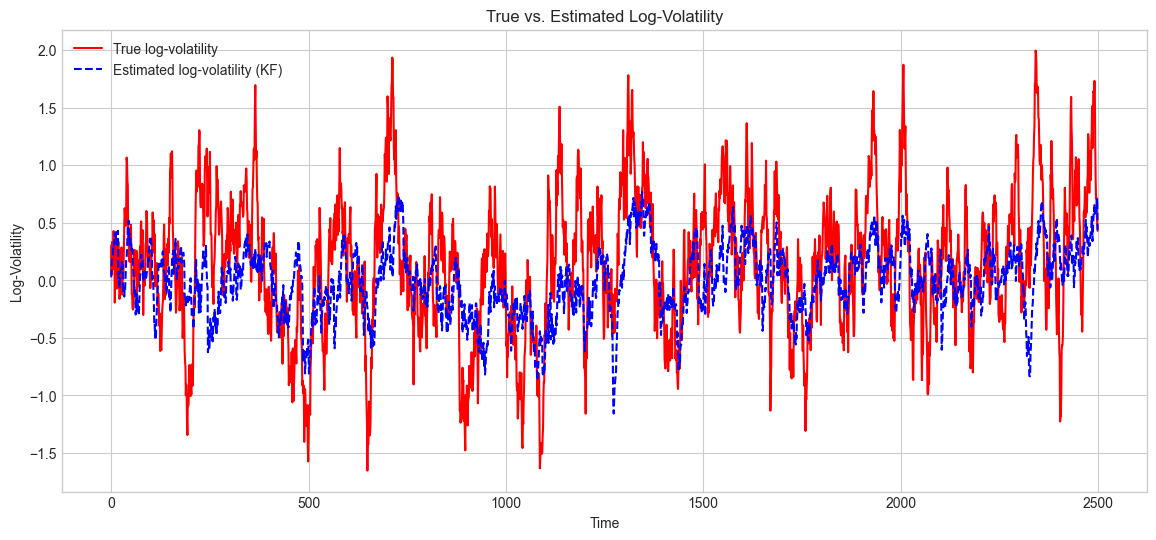

In [7]:
# Mean of log(χ²(1))
mu_logchi = -1.27

a = np.log(sigma_hat**2) + mu_logchi

# TODO: Run Kalman Filter with estimated parameters
B = 1.0
Phi = phi_hat
H = np.pi**2 / 2
Q = sigma_eta_hat**2
a1 = 0.0
P1 = Q / (1 - Phi**2)
a_post_hat, P_post_hat, _, _ = kalman_filter(y, a, B, Phi, H, Q, a1, P1)  # Replace with your Kalman Filter call

# Plot the true log-volatility vs. the estimated log-volatility
plt.figure(figsize=(14, 6))
plt.plot(h_true, 'r-', label='True log-volatility')
plt.plot(a_post_hat, 'b--', label='Estimated log-volatility (KF)')
plt.legend()
plt.title('True vs. Estimated Log-Volatility')
plt.xlabel('Time')
plt.ylabel('Log-Volatility')
plt.grid(True)
plt.show()

## Part 4: EGARCH(1,1) Model

For comparison, let's also fit an EGARCH(1,1) model to the same data.

### Task 4.1: Fit an EGARCH(1,1) Model

Complete the code to fit an EGARCH(1,1) model to our simulated returns:

In [8]:
# TODO: Fit EGARCH(1,1) model
# Your code here
am = arch_model(r, vol='EGARCH', p=1, o=1, q=1, dist='normal')
res = am.fit(disp='off')

# TODO: Extract conditional volatility
egarch_vol = res.conditional_volatility

# TODO: Calculate EGARCH "log-vol" = log(egarch_vol^2) = 2*log(egarch_vol)
log_egarch_vol = 2 * np.log(egarch_vol)

# Display model summary
print(res.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3839.18
Distribution:                  Normal   AIC:                           7688.35
Method:            Maximum Likelihood   BIC:                           7717.47
                                        No. Observations:                 2500
Date:                Wed, Jun 04 2025   Df Residuals:                     2499
Time:                        15:42:03   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0118  2.183e-02      0.542      0.588 

## Part 5: Computing Value-at-Risk (VaR) and Expected Shortfall (ES)

Now we'll compute Value-at-Risk (VaR) and Expected Shortfall (ES) using our volatility estimates.

For a normal distribution with zero mean and time-varying volatility:

* VaR$_\alpha(t) = z_\alpha \times \sigma_t$ where $z_\alpha$ is the $\alpha$-quantile of the standard normal distribution
* ES$_\alpha(t) = -\sigma_t \times \frac{\phi(z_\alpha)}{\alpha}$ where $\phi(z)$ is the PDF of the standard normal distribution

### Task 5.1: Implement VaR and ES Function

Complete the function to compute VaR and ES:

In [9]:
def VaR_ES(stddev, alpha=0.05):
    """
    Given a vector of stddev[t], compute the left-tail VaR_α[t] and ES_α[t].
    VaR_α is negative; ES_α is even more negative.
    
    Parameters
    ----------
    stddev : array-like
        Time series of standard deviations
    alpha : float, default=0.05
        Confidence level (e.g., 0.05 for 5%)
        
    Returns
    -------
    var_ : array-like
        Value-at-Risk time series
    es_ : array-like
        Expected Shortfall time series
    """
    # TODO: Calculate the quantile of standard normal distribution
    z = norm.ppf(alpha)
    
    # TODO: Calculate the PDF of the standard normal at z
    pdf_z = norm.pdf(z)
    
    # TODO: Calculate VaR and ES
    var_ = z * stddev
    es_ = -stddev * pdf_z / alpha
    
    return var_, es_

### Task 5.2: Calculate VaR and ES for Both Models

Compute the VaR and ES measures using both our Kalman Filter and EGARCH estimates:

In [10]:
# Set confidence level
alpha = 0.05

# TODO: For Kalman Filter approach: stddev[t] = exp(0.5 * log-vol[t])
std_kf = np.exp(0.5 * a_post_hat)
std_egarch = egarch_vol
# TODO: Calculate VaR and ES for Kalman Filter approach
var_kf, es_kf = VaR_ES(std_kf, alpha)

# TODO: For EGARCH approach: Calculate VaR and ES
var_garch, es_garch = VaR_ES(std_egarch, alpha)

## Part 6: Evaluate Model Performance

### Task 6.1: Implement Coverage Ratio Function

Complete the function to calculate the coverage ratio:

In [11]:
def coverage_ratio(returns, var_array):
    """
    Fraction of times r_t < VaR_t.
    Expect coverage ~ alpha if VaR_t is the alpha-quantile (negative).
    
    Parameters
    ----------
    returns : array-like
        Time series of returns
    var_array : array-like
        Time series of Value-at-Risk estimates (negative for left tail)
        
    Returns
    -------
    float
        Fraction of times returns exceeded VaR
    """
    # TODO: Calculate and return the coverage ratio
    ##violations = returns < var_array
    ##ratio = np.mean(violations)
    ##return ratio
    return np.mean(returns < var_array)

### Task 6.2: Calculate and Compare Coverage Ratios

In [12]:
# TODO: Calculate coverage ratios for both approaches
cov_kf = coverage_ratio(r, var_kf)
cov_garch = coverage_ratio(r, var_garch)
# Print results
print("EGARCH(1,1) parameter estimates:\n", res.params)
print(f"\nKF VaR coverage = {100*cov_kf:.2f}% (expected {alpha*100}%)")
print(f"EGARCH VaR coverage = {100*cov_garch:.2f}% (expected {alpha*100}%)")

EGARCH(1,1) parameter estimates:
 mu          0.011833
omega       0.024804
alpha[1]    0.237034
gamma[1]    0.007683
beta[1]     0.904332
Name: params, dtype: float64

KF VaR coverage = 6.48% (expected 5.0%)
EGARCH VaR coverage = 5.00% (expected 5.0%)


## Part 7: Visualize Results

### Task 7.1: Create Comparative Plots

Create plots to visualize and compare the results:

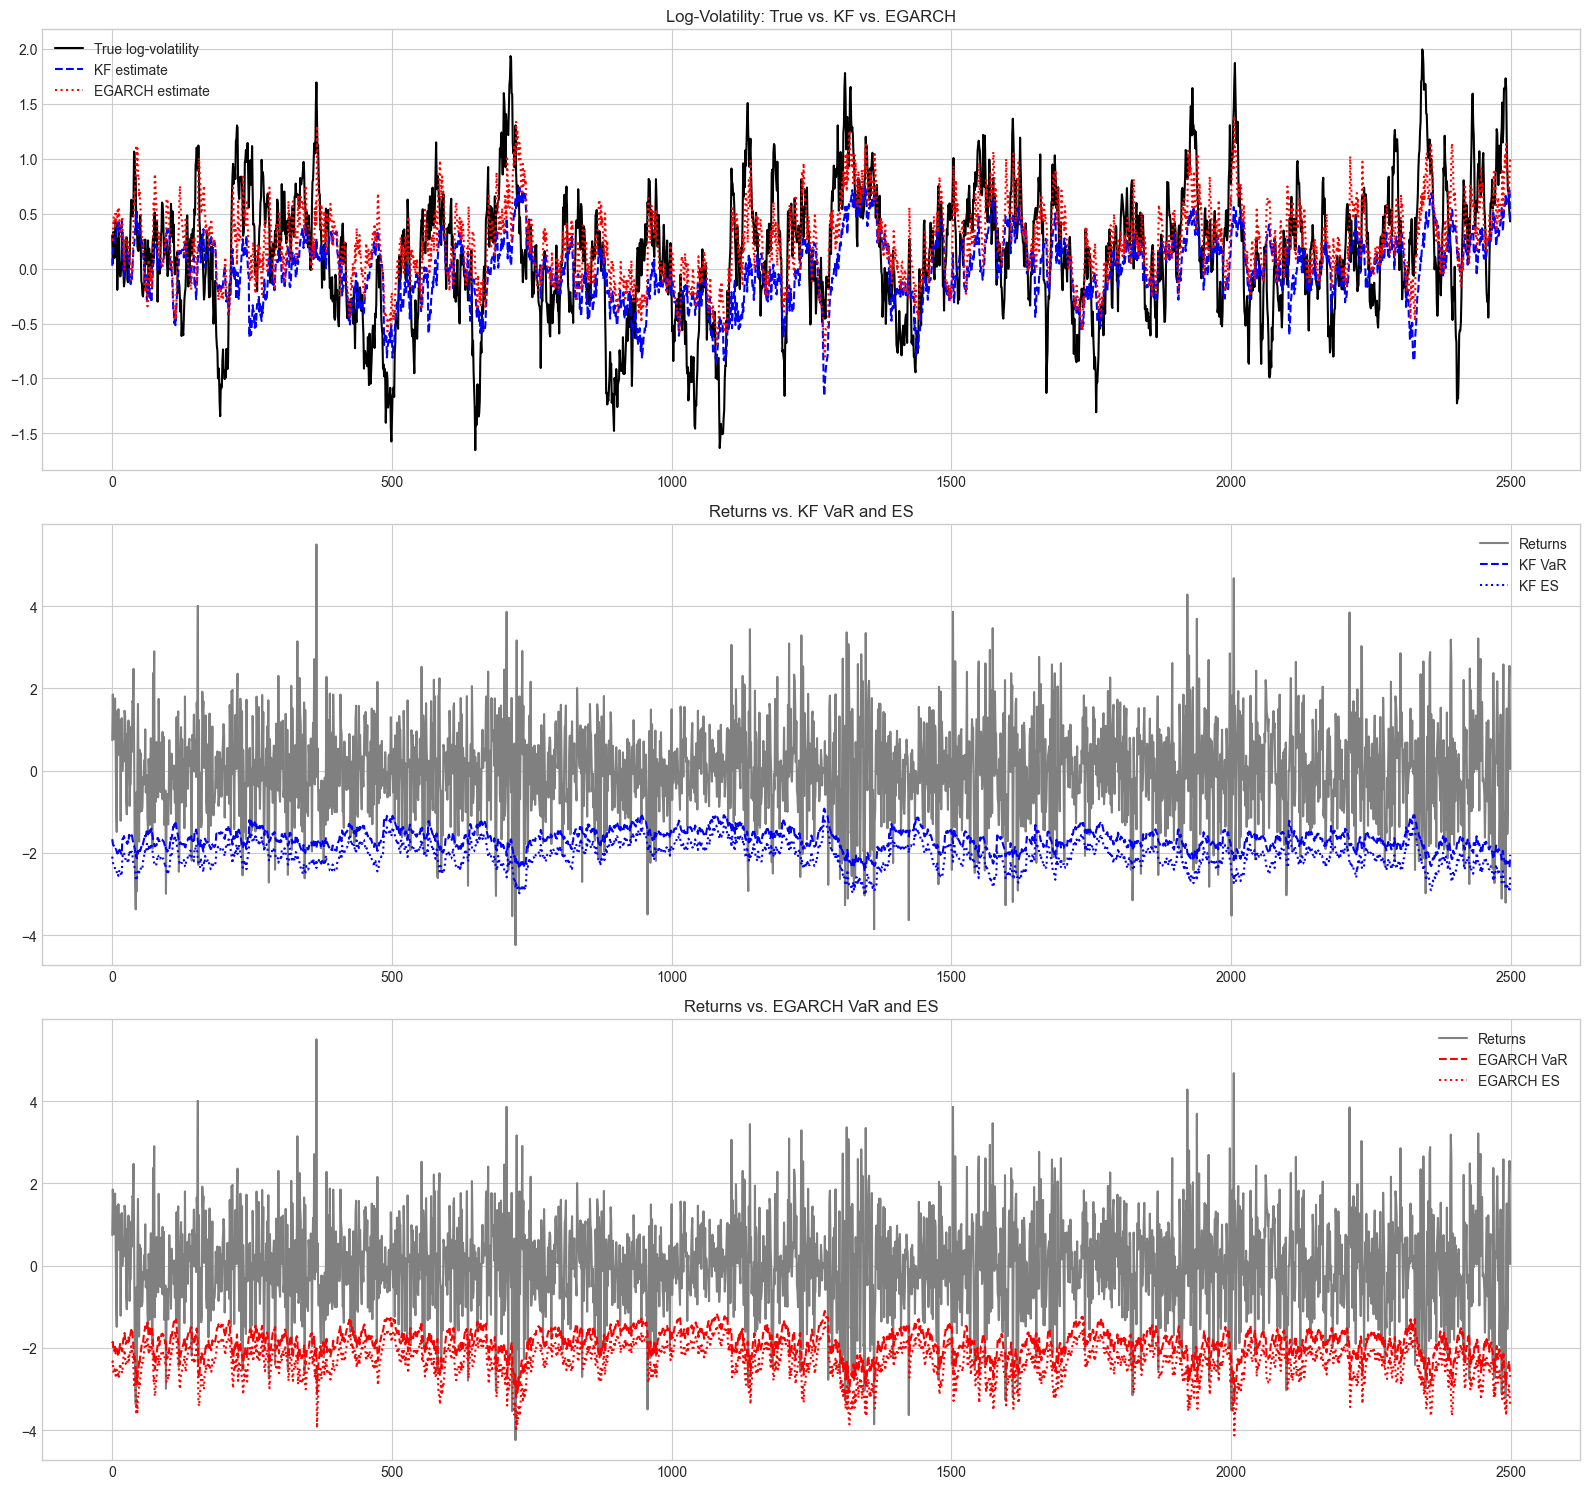

In [13]:
plt.figure(figsize=(16, 15))

# TODO: Plot 1: Compare log-volatility estimates
plt.subplot(3, 1, 1)
plt.plot(h_true, label='True log-volatility', color='black')
plt.plot(a_post_hat, label='KF estimate', linestyle='--', color='blue')
plt.plot(log_egarch_vol, label='EGARCH estimate', linestyle=':', color='red')
plt.title('Log-Volatility: True vs. KF vs. EGARCH')
plt.legend()
plt.grid(True)

# TODO: Plot 2: Returns vs. KF VaR and ES
plt.subplot(3, 1, 2)
plt.plot(r, label='Returns', color='gray')
plt.plot(var_kf, label='KF VaR', color='blue', linestyle='--')
plt.plot(es_kf, label='KF ES', color='blue', linestyle=':')
plt.title('Returns vs. KF VaR and ES')
plt.legend()
plt.grid(True)

# TODO: Plot 3: Returns vs. EGARCH VaR and ES
plt.subplot(3, 1, 3)
plt.plot(r, label='Returns', color='gray')
plt.plot(var_garch, label='EGARCH VaR', color='red', linestyle='--')
plt.plot(es_garch, label='EGARCH ES', color='red', linestyle=':')
plt.title('Returns vs. EGARCH VaR and ES')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Conclusion

In this problem set, you've implemented and compared two different approaches for estimating financial risk measures. You've learned how to:

1. Implement a Kalman Filter for stochastic volatility models
2. Use Maximum Likelihood Estimation for parameter optimization
3. Compute and interpret Value-at-Risk (VaR) and Expected Shortfall (ES)
4. Compare the performance of different volatility models